In [2]:
import argparse

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms
from ImageDataset import *
from unet import *
from loss import *
import os 
import zipfile
from helper import *

## Unzip The Data  
Only if running on google colab


In [4]:

data_path = 'data.zip'
pred_path = 'predictions.zip'


with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall()

with zipfile.ZipFile(pred_path, 'r') as zip_ref:
    zip_ref.extractall()


In [20]:
TRAIN_IMAGES = 'data/training/images/'
GROUNDTRUTH = 'data/training/groundtruth/'
TEST_IMAGES = 'data/test_set_images/'
FOREGROUND_TRESHOLD = 0.25
SPLIT_RATIO = 0.9
BATCH_SIZE = 10
EPOCHS = 30
LR = 1e-3
SEED = 0
WEIGHT_DECAY = 1e-3
WORKERS = 2

In [12]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
pin_memory = device == 'cuda'

Device: cpu


In [4]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
])
mask_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [5]:
dataset = ImagesDataset(
    img_dir=TRAIN_IMAGES,
    gt_dir=GROUNDTRUTH,
    image_transform=image_transform,
    mask_transform=mask_transform,
)

In [6]:
len(dataset)

100

In [7]:
image, mask = dataset[0]
print('Image size:', image.shape)
print('Mask size:', mask.shape)

Image size: torch.Size([3, 400, 400])
Mask size: torch.Size([1, 400, 400])


In [8]:
train_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)

In [9]:
model= UNet().to(device)

In [10]:
criterion = DiceLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [11]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    patience=5,
    verbose=True,
)

In [12]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm


# Set the model in training mode
model.train()

# Define the number of training epochs
epochs = 100  # You can adjust this as needed

# Training loop
for epoch in range(epochs):
    total_loss = 0.0

    # Iterate over the training data
    for data, target in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
        # Send the input to the device
        data, target = data.to(device), target.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the total loss
        total_loss += loss.item()

    # Average loss for the epoch
    average_loss = total_loss / len(train_loader)
    print(f"average loss: ", average_loss)

    # Adjust learning rate if a scheduler is provided
    if lr_scheduler is not None:
        lr_scheduler.step(average_loss)

torch.save(model.state_dict(), 'trained_model_10ep_30batch.pth')

Epoch 1/10: 100%|██████████| 10/10 [03:12<00:00, 19.28s/batch]


average loss:  0.6479327440261841


Epoch 2/10: 100%|██████████| 10/10 [03:05<00:00, 18.56s/batch]


average loss:  0.5524351000785828


Epoch 3/10: 100%|██████████| 10/10 [03:10<00:00, 19.05s/batch]


average loss:  0.5209612488746643


Epoch 4/10: 100%|██████████| 10/10 [03:09<00:00, 18.95s/batch]


average loss:  0.4906199038028717


Epoch 5/10: 100%|██████████| 10/10 [03:10<00:00, 19.06s/batch]


average loss:  0.45297694206237793


Epoch 6/10: 100%|██████████| 10/10 [03:11<00:00, 19.19s/batch]


average loss:  0.4200475513935089


Epoch 7/10: 100%|██████████| 10/10 [03:15<00:00, 19.57s/batch]


average loss:  0.4059355616569519


Epoch 8/10: 100%|██████████| 10/10 [03:22<00:00, 20.30s/batch]


average loss:  0.3777090311050415


Epoch 9/10: 100%|██████████| 10/10 [03:21<00:00, 20.15s/batch]


average loss:  0.3745973765850067


Epoch 10/10: 100%|██████████| 10/10 [03:28<00:00, 20.88s/batch]

average loss:  0.3589638650417328


## Testing and submission

In [22]:
test_image_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [24]:
test_set = ImagesDataset(
    img_dir=TEST_IMAGES,
    image_transform=test_image_transform,
)

In [25]:
test_loader = DataLoader(
    dataset=test_set,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)

In [13]:
predictions_path= 'predictions/'

In [14]:
prediction_filnames = list()

In [16]:
#Run this only if you load the model
model= UNet().to(device)
state_dict = torch.load('models/trained_model_100ep_10batch.pth', map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# Set the model in evaluation mode
model.eval()

# Switch off autograd
with torch.no_grad():
    # Loop over the dataset
    for i, (data, target) in enumerate(test_loader):
        filename = create_filename(len(test_loader),i)
        print(f'Processing {filename}')

        # Send the input to the device
        data = data.to(device)
        if target.dim() != 1:
            target = target.to(device)

        # Make the predictions
        output = model(data)

        # Get labels
        output = get_label(output, 0.25)

        # Save mask
        output_path = os.path.join(predictions_path, filename)
        save_prediction(output, output_path)
        prediction_filnames.append(output_path)

# Print a message after processing all images
print('Prediction completed.')


In [1]:
from helper import *

In [3]:
process_images('predictions/','improved_preds')

In [4]:
image_names = [f for f in os.listdir('improved_preds') if f.endswith(('.png', '.jpg', '.jpeg'))]


In [6]:
filenames= list()
for name in image_names:
    new_name = os.path.join('improved_preds', name)
    filenames.append(new_name)
    

In [7]:
from helper import *
masks_to_submission('submission.csv', *filenames)

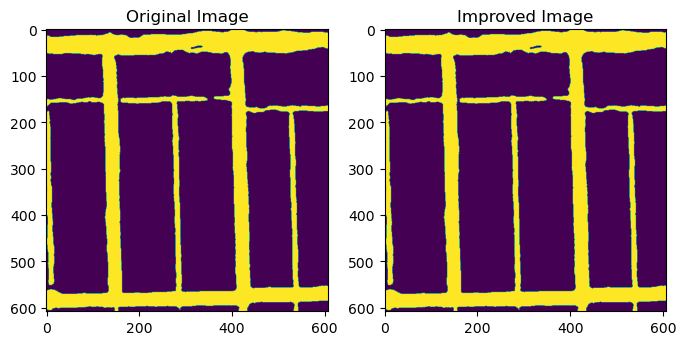

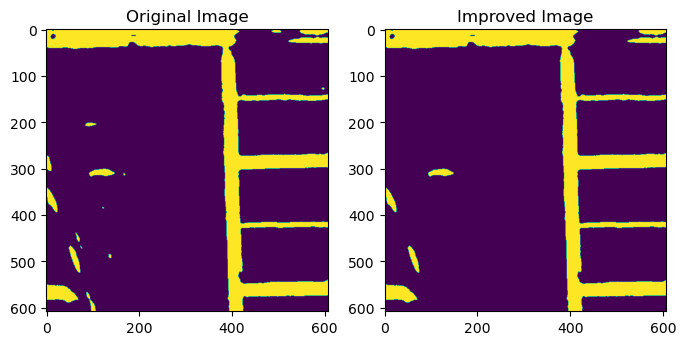

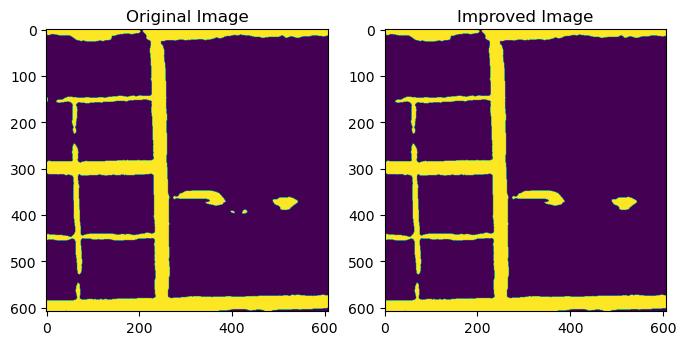

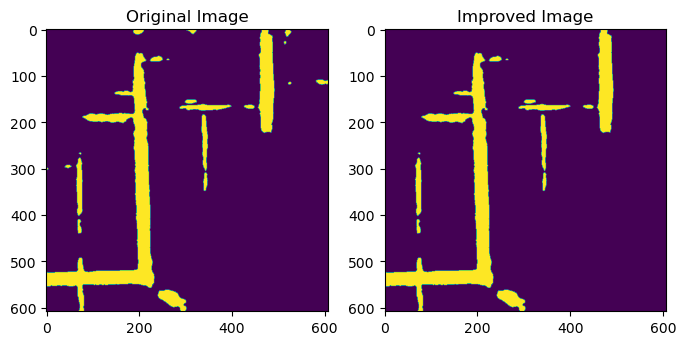

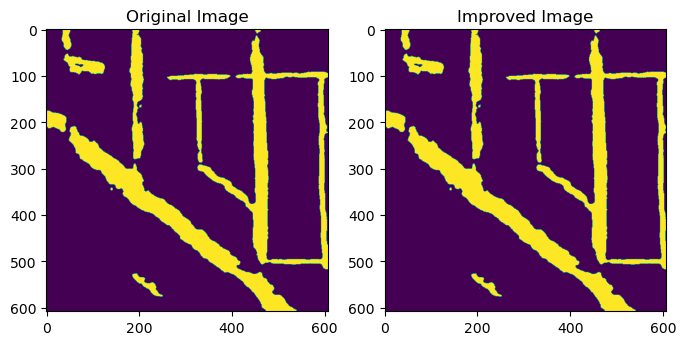

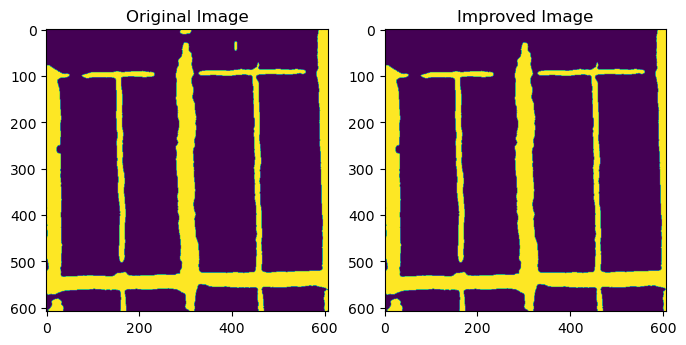

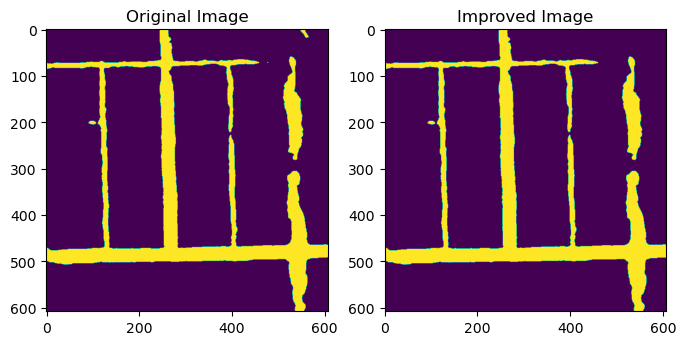

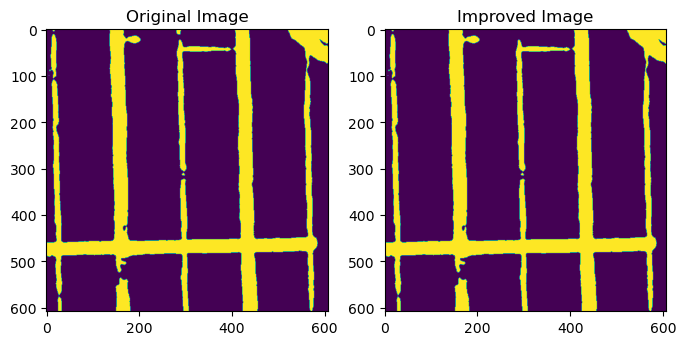

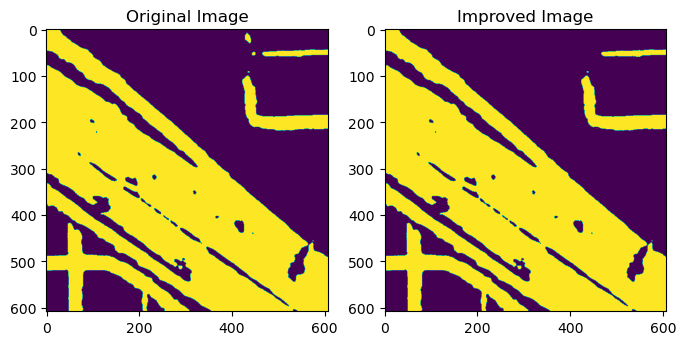

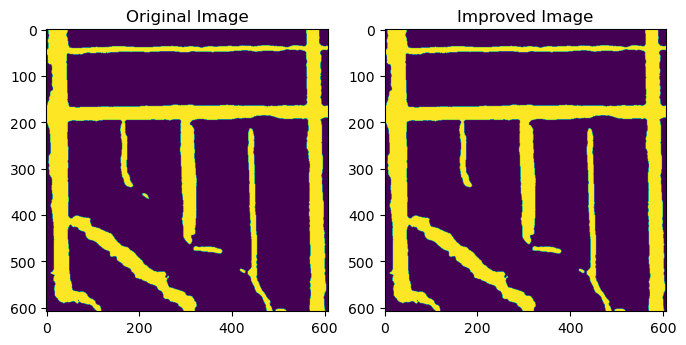

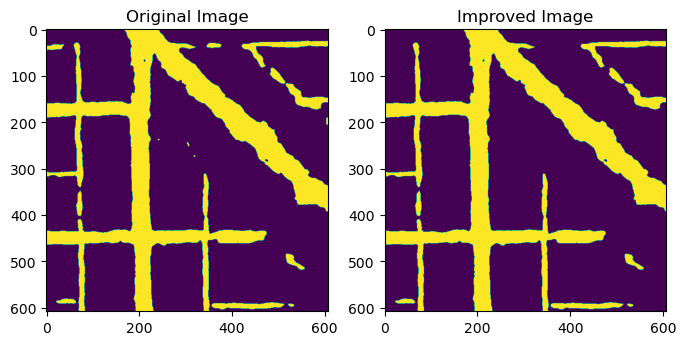

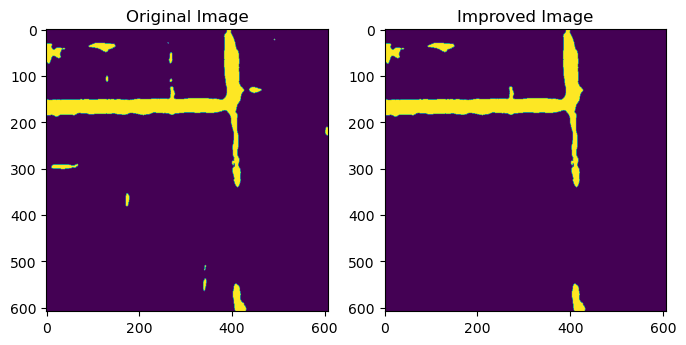

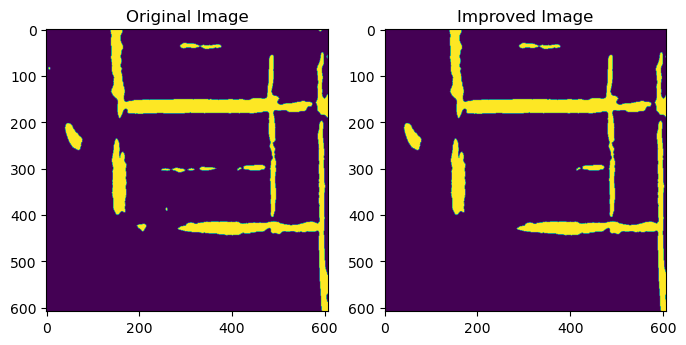

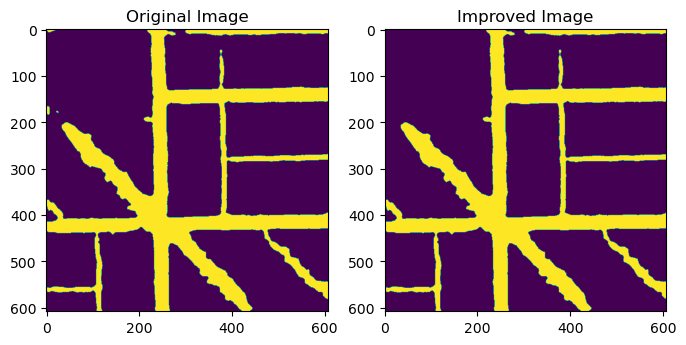

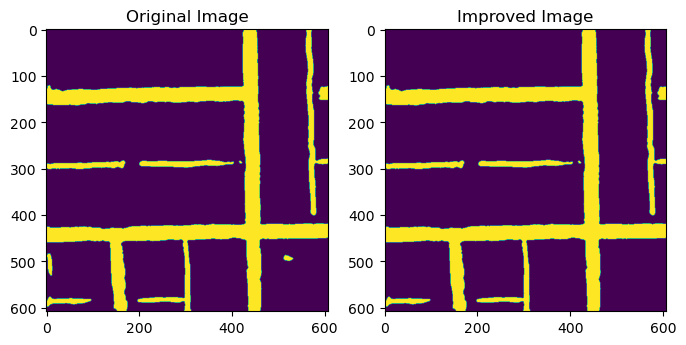

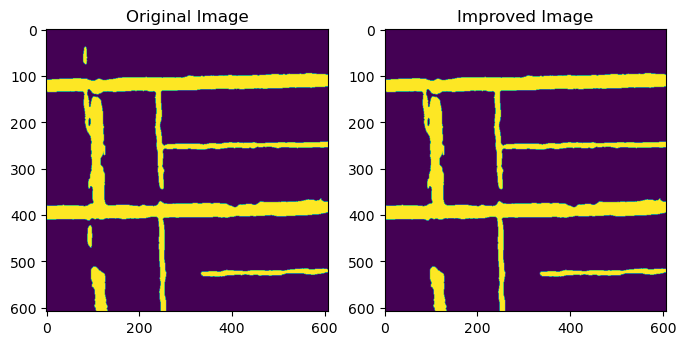

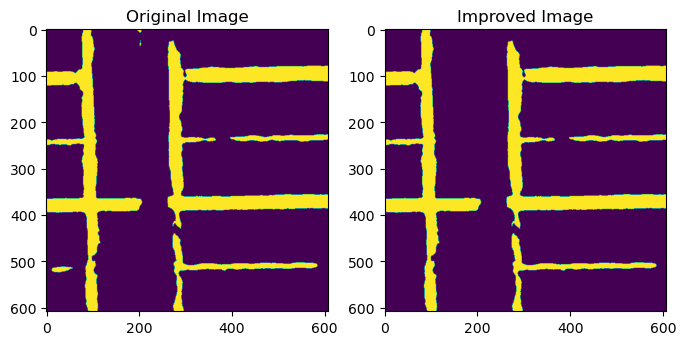

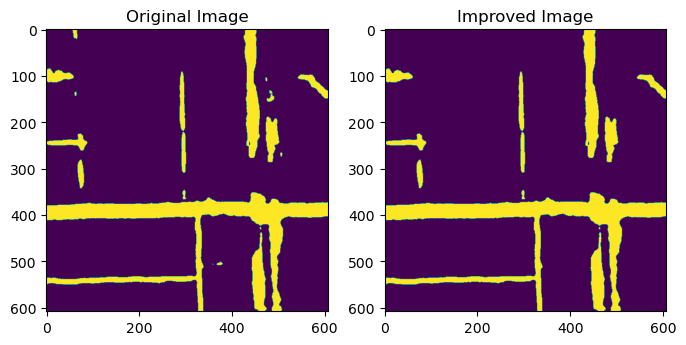

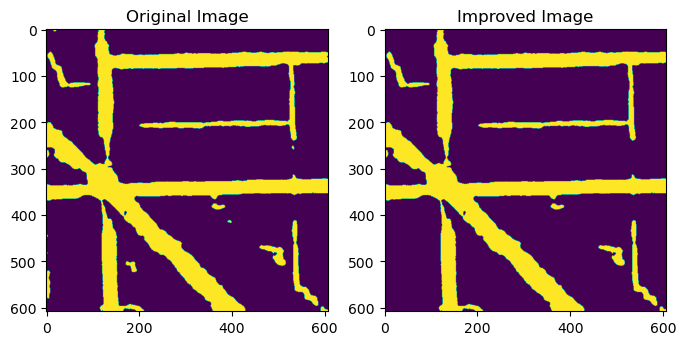

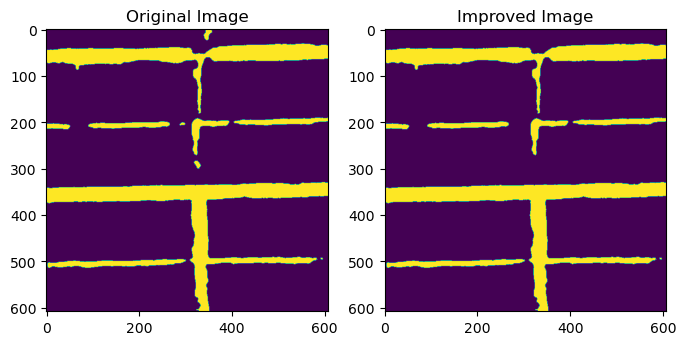

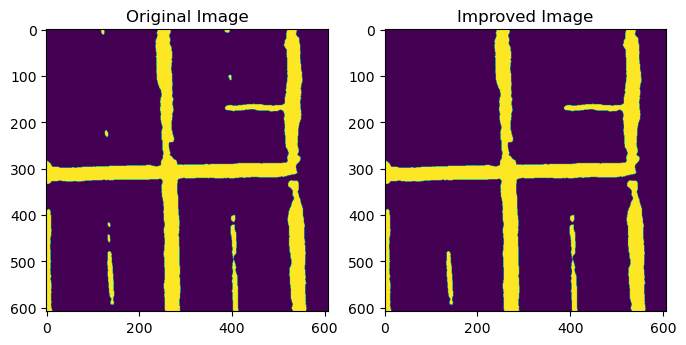

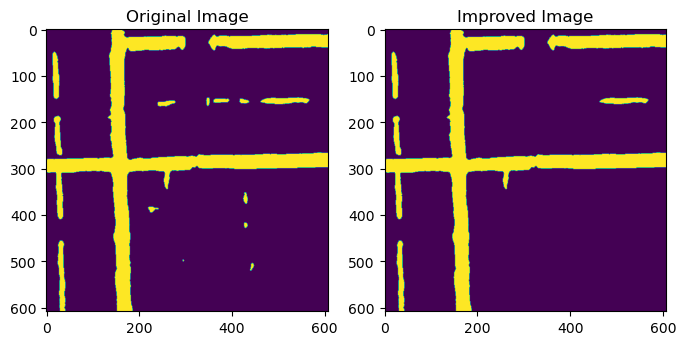

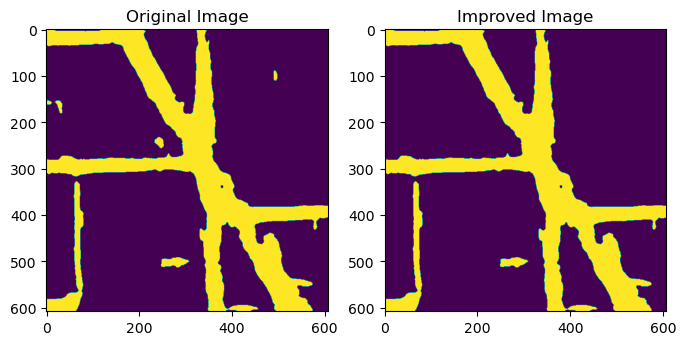

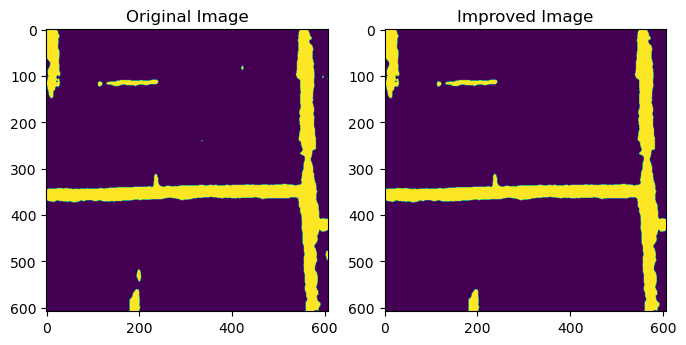

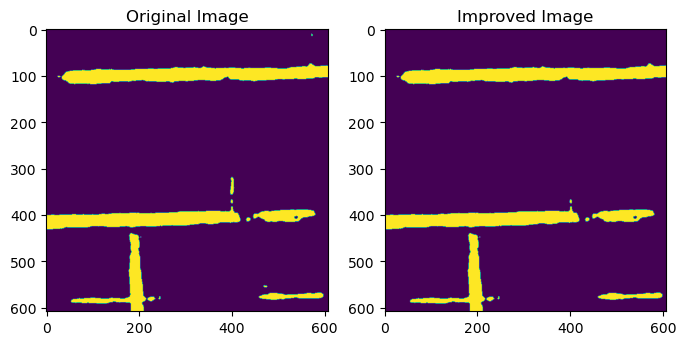

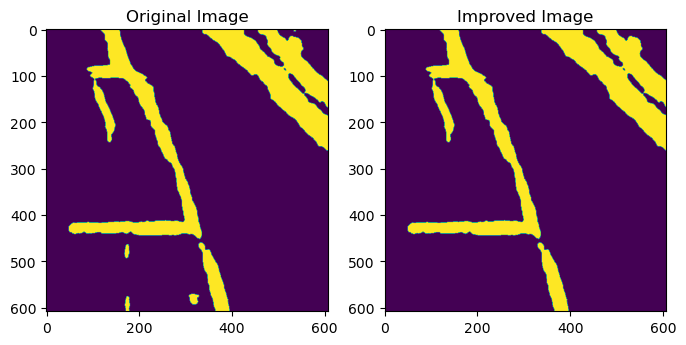

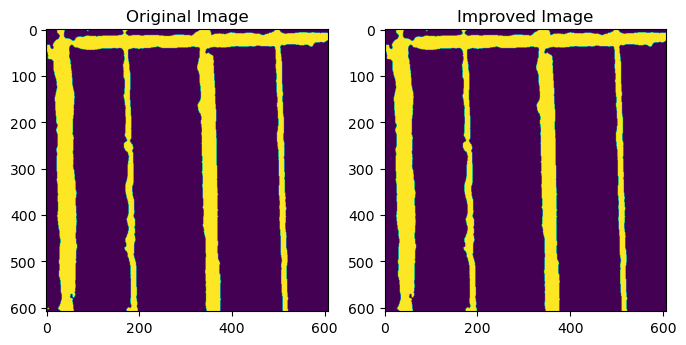

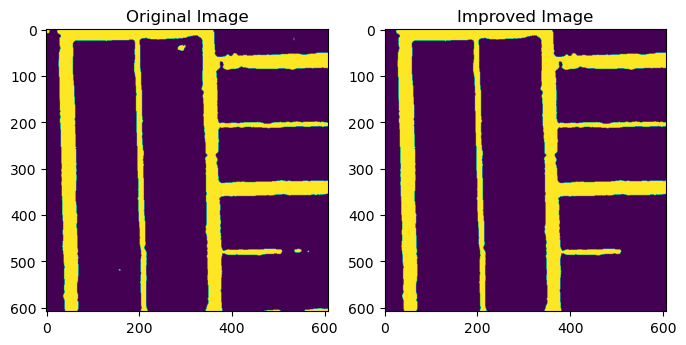

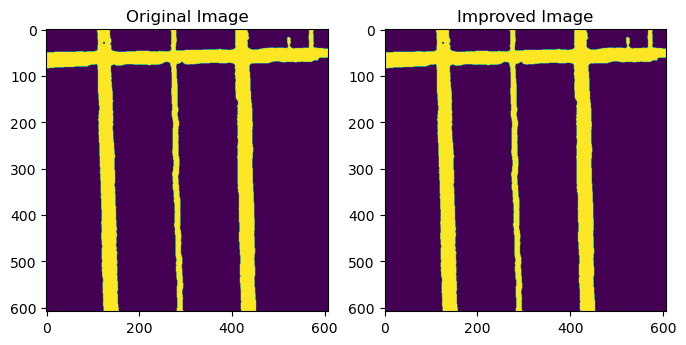

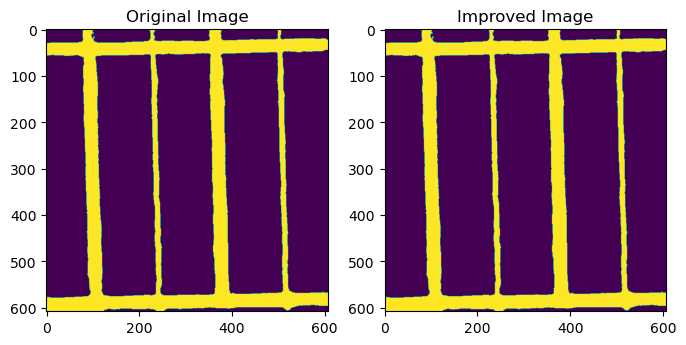

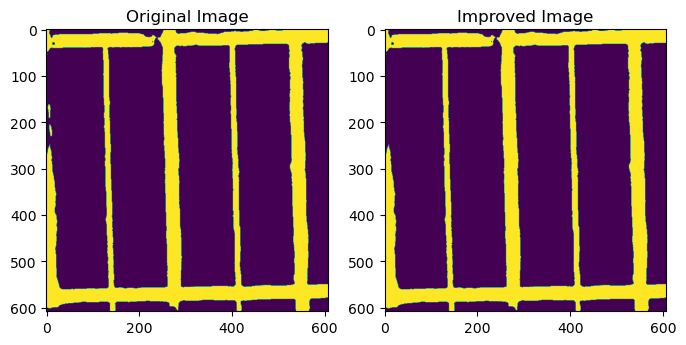

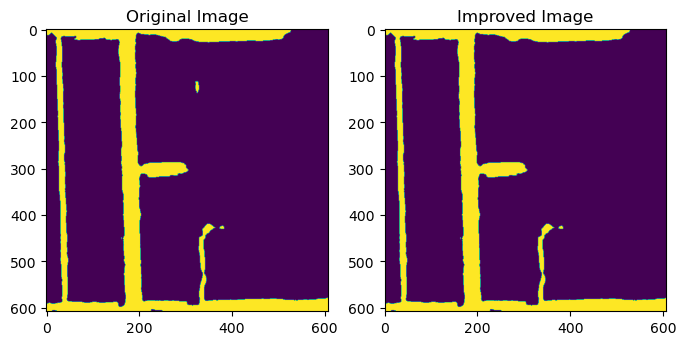

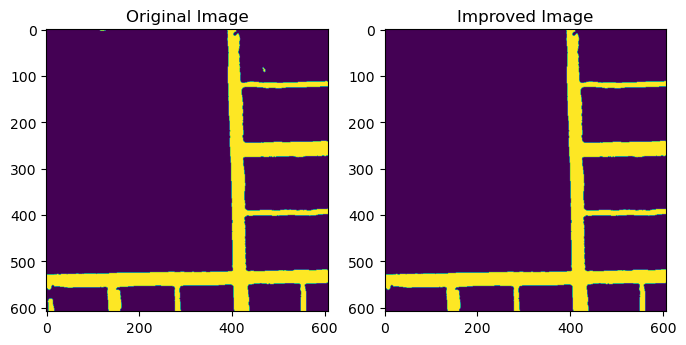

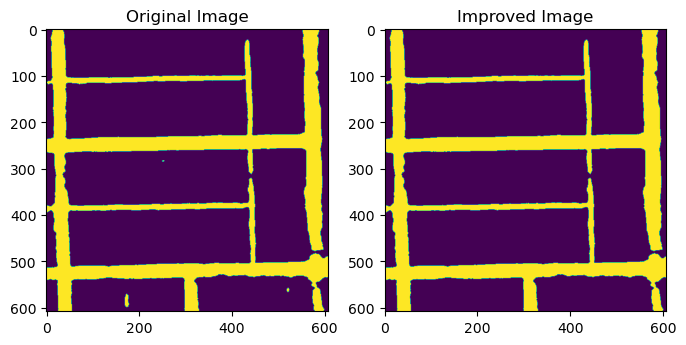

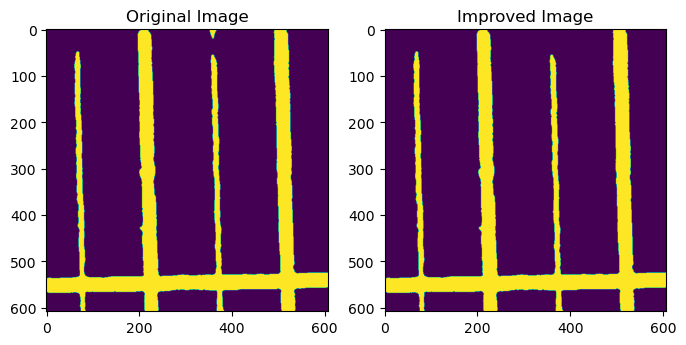

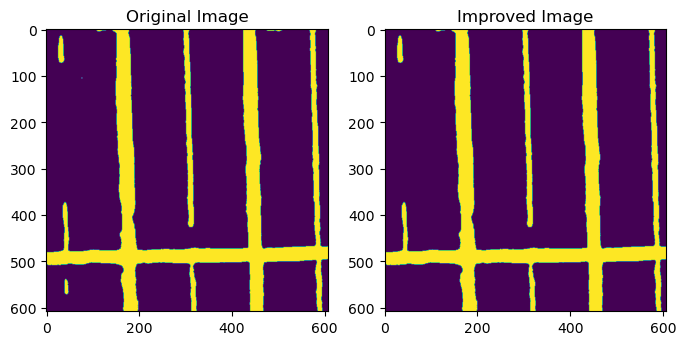

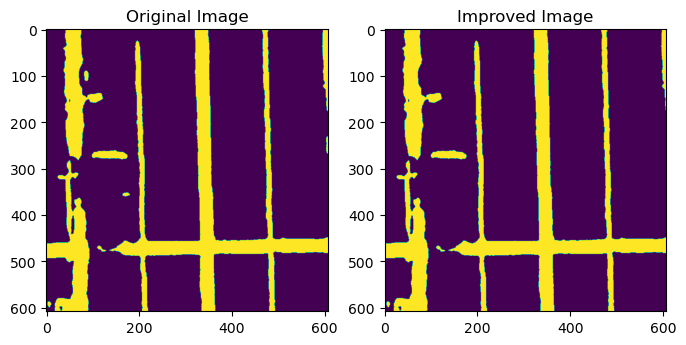

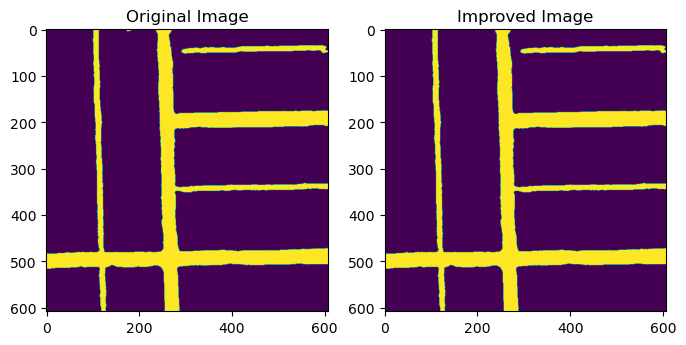

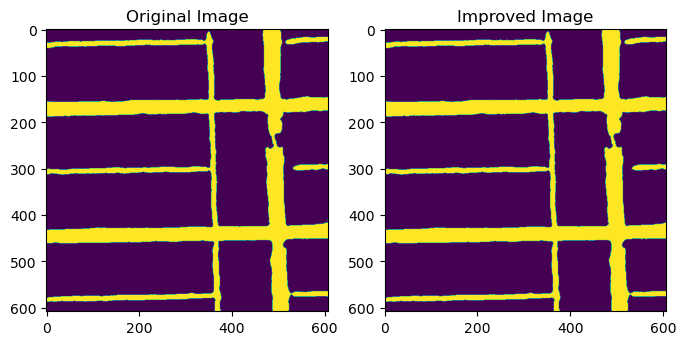

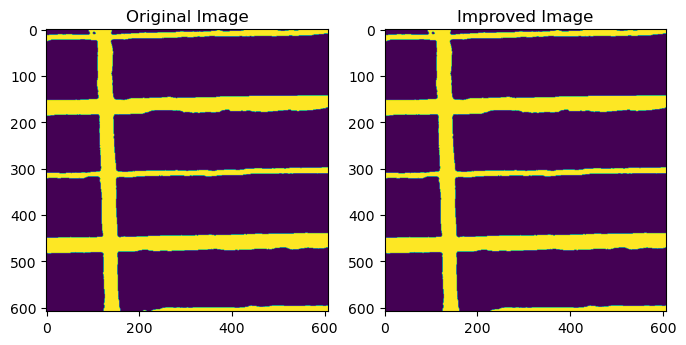

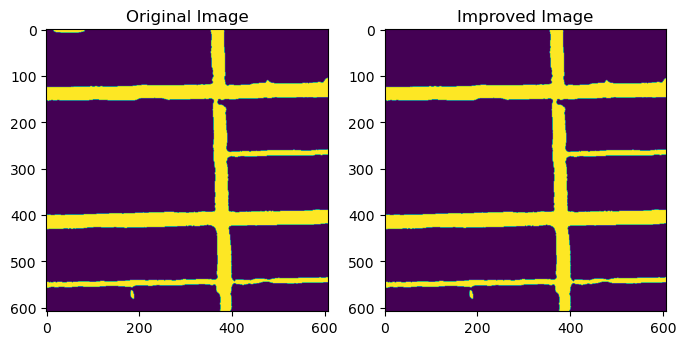

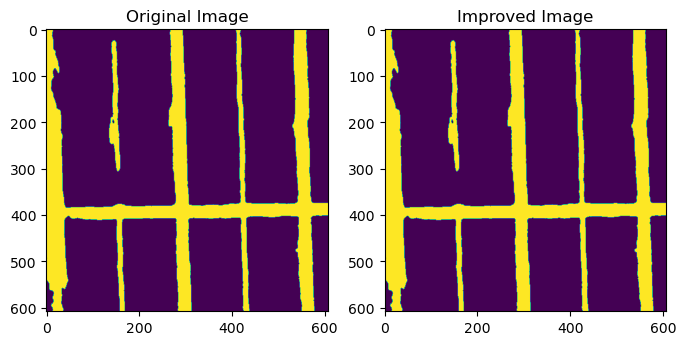

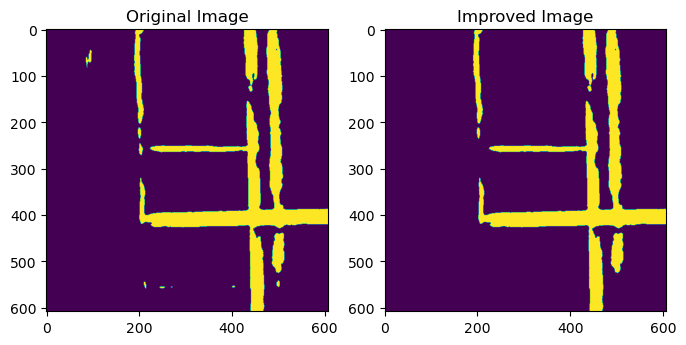

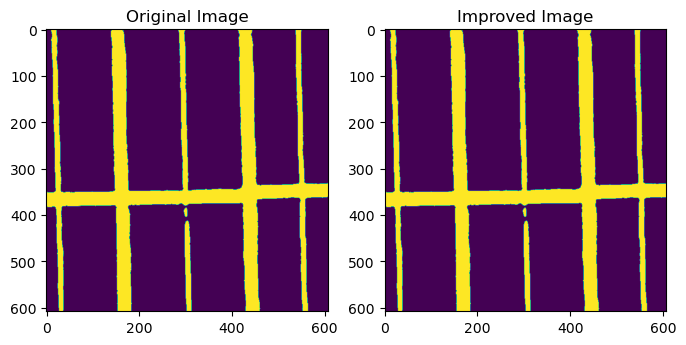

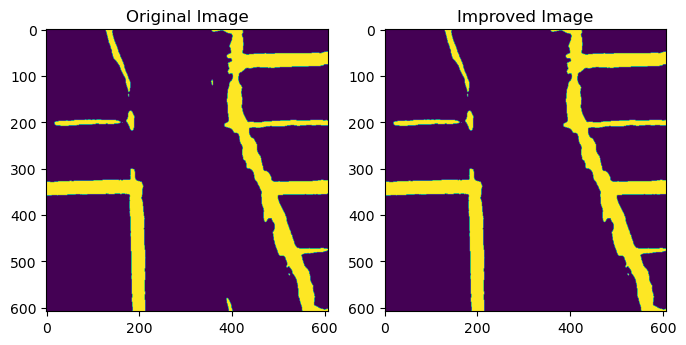

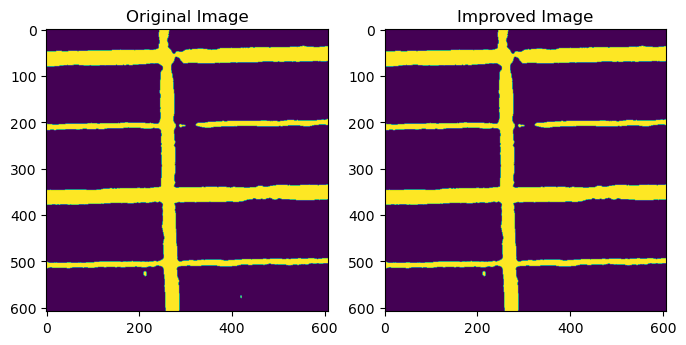

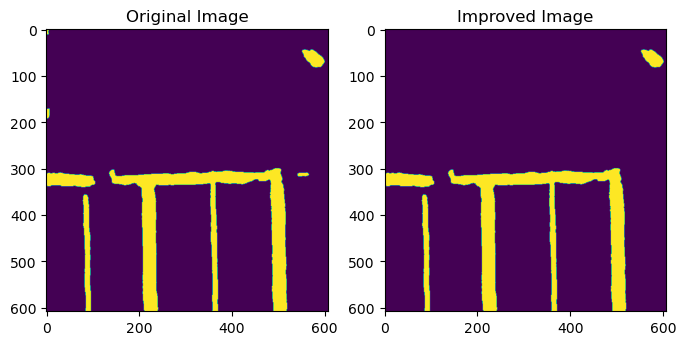

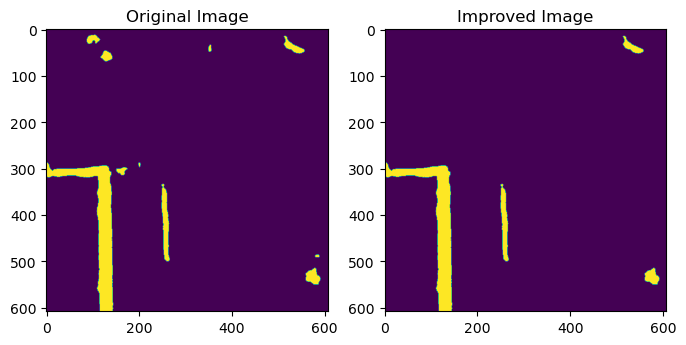

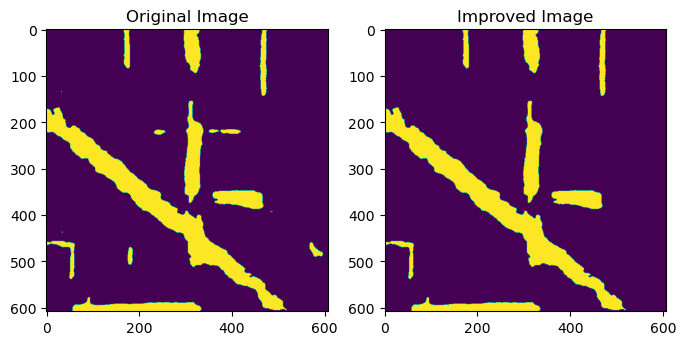

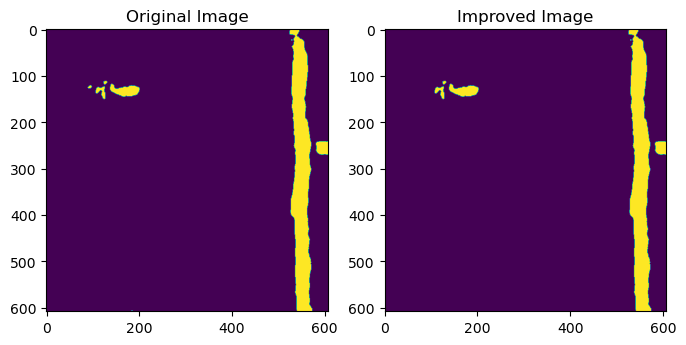

In [5]:
import matplotlib.pyplot as plt

# Plot each pair of images
for image_file in image_names:
    # Load the original image from 'predictions' folder
    predictions_path = os.path.join('predictions/', image_file)
    original_image = Image.open(predictions_path)

    # Load the improved image from 'improved_preds' folder
    improved_preds_path = os.path.join('improved_preds/', image_file)
    improved_image = Image.open(improved_preds_path)

    # Plot the images side by side
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(improved_image)
    plt.title('Improved Image')

    plt.show()
